
 Titanic Survival Prediction: Data Preprocessing and Pipeline Approach

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, learning_curve, GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

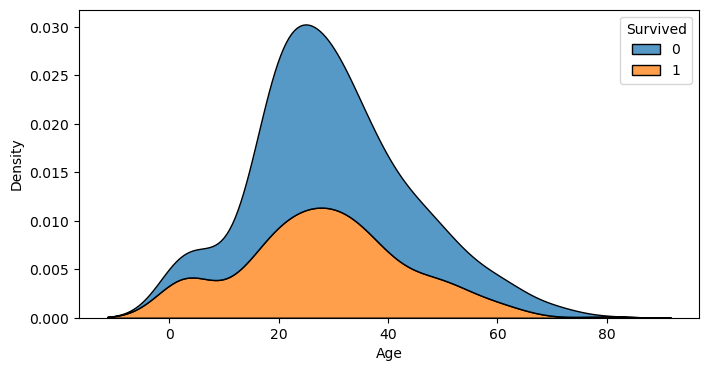

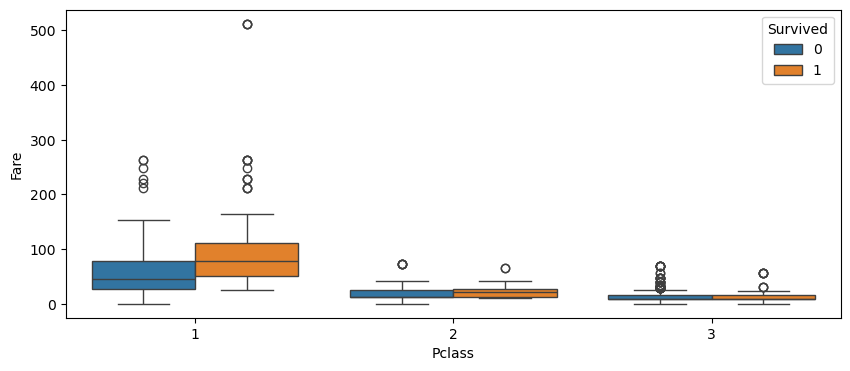

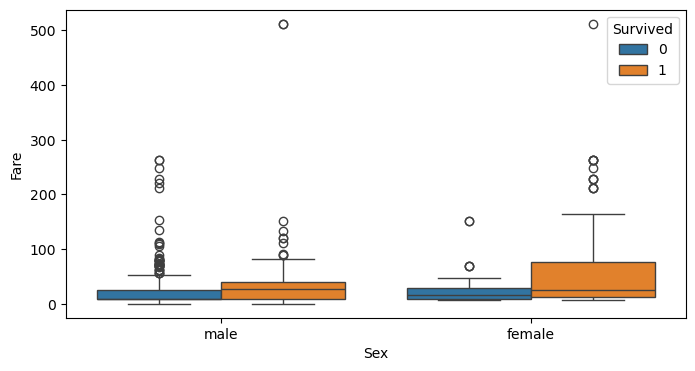

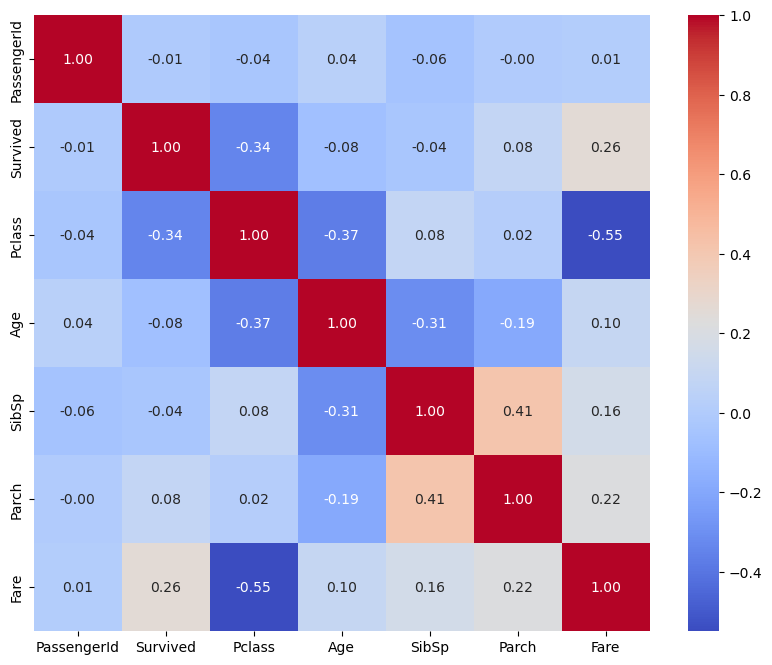

In [3]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df_raw, x="Age", hue="Survived", multiple="stack")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=df_raw, x="Pclass", y="Fare", hue="Survived")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=df_raw, x="Sex", y="Fare", hue="Survived")
plt.show()

plt.figure(figsize=(10,8))
numeric_df = df_raw.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

In [4]:
df = df_raw.copy()
df = df.drop(["PassengerId","Name","Ticket","Cabin"], axis=1)
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
df = pd.get_dummies(df, columns=["Sex","Embarked","Pclass"], drop_first=True)

In [5]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set:", X_train.shape, "Validation set:", X_val.shape)

Training set: (712, 11) Validation set: (179, 11)


RF Train Acc: 0.851123595505618
RF Val Acc: 0.8044692737430168
RF Val F1: 0.7954406180141593
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       110
           1       0.85      0.59      0.70        69

    accuracy                           0.80       179
   macro avg       0.82      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



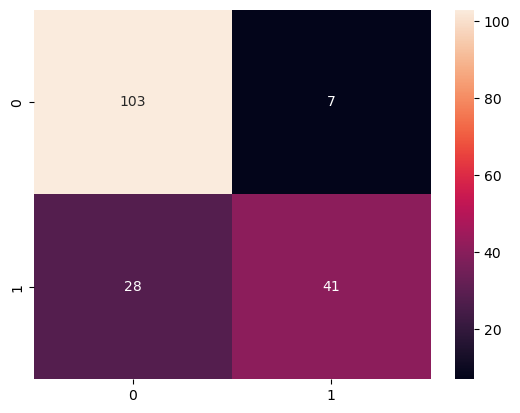

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
print("RF Train Acc:", rf.score(X_train, y_train))
y_pred = rf.predict(X_val)
print("RF Val Acc:", accuracy_score(y_val, y_pred))
print("RF Val F1:", f1_score(y_val, y_pred, average="weighted"))
print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

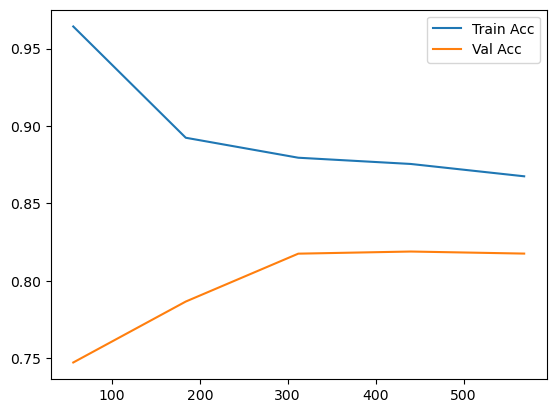

In [7]:
train_sizes, train_scores, val_scores = learning_curve(
    rf, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1,1.0,5), scoring="accuracy"
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
plt.plot(train_sizes, train_mean, label="Train Acc")
plt.plot(train_sizes, val_mean, label="Val Acc")
plt.legend()
plt.show()

In [8]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
print("LR Val Acc:", lr.score(X_val, y_val))

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
print("MLP Val Acc:", mlp.score(X_val, y_val))

LR Val Acc: 0.8212290502793296
MLP Val Acc: 0.7821229050279329


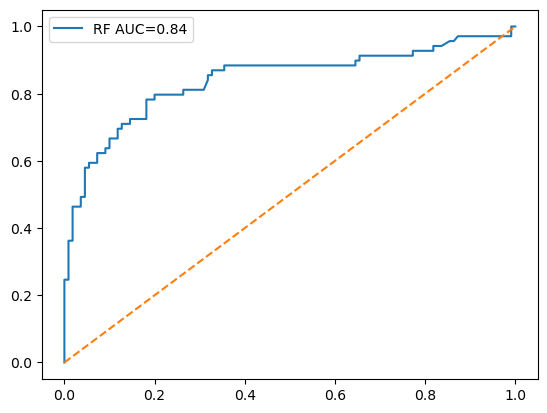

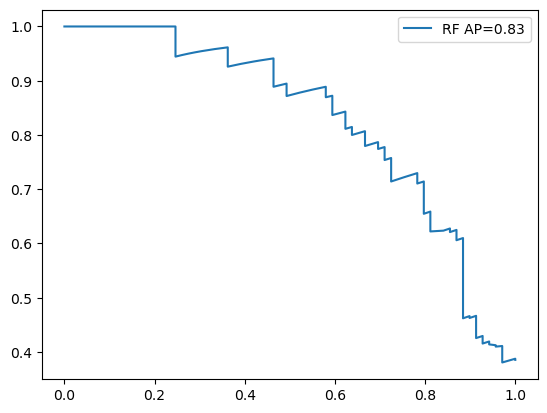

In [9]:
y_prob = rf.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"RF AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],"--")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_prob)
ap = average_precision_score(y_val, y_prob)
plt.plot(recall, precision, label=f"RF AP={ap:.2f}")
plt.legend()
plt.show()

In [10]:
param_grid = {"n_estimators":[50,100,200],"max_depth":[3,5,8]}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid, cv=3, scoring="accuracy", n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Grid Acc:", grid.best_score_)
best_rf = grid.best_estimator_

Best params: {'max_depth': 5, 'n_estimators': 100}
Grid Acc: 0.8272406008817029


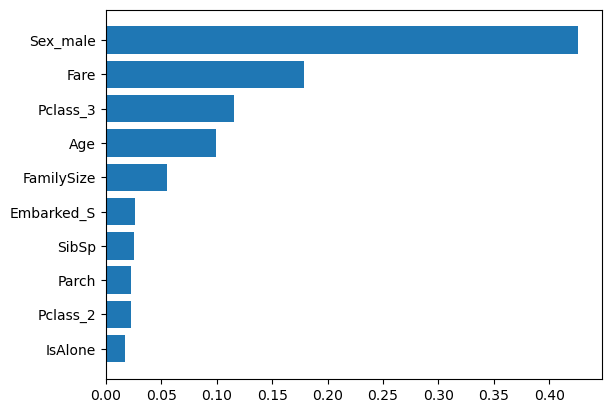

In [11]:
feat_df = pd.DataFrame({
    "feature": X.columns,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False)
plt.barh(feat_df["feature"][:10], feat_df["importance"][:10])
plt.gca().invert_yaxis()
plt.show()

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

raw = pd.read_csv("train.csv").drop(
    ["PassengerId","Name","Ticket","Cabin"], axis=1
)
X_pipe = raw.drop("Survived", axis=1)
y_pipe = raw["Survived"]

num_feats = ["Age","SibSp","Parch","Fare"]
cat_feats = ["Sex","Embarked","Pclass"]

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(drop="first"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_feats),
    ("cat", cat_pipe, cat_feats)
])

pipe = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ))
])

Xtr, Xv, ytr, yv = train_test_split(
    X_pipe, y_pipe, test_size=0.2, random_state=42, stratify=y_pipe
)

pipe.fit(Xtr, ytr)
print("Pipeline Val Acc:", pipe.score(Xv, yv))

joblib.dump(pipe, "titanic_pipeline.pkl")

sample = Xv.iloc[[0]]
print("Prediction:", pipe.predict(sample))
print("Probabilities:", pipe.predict_proba(sample))


Pipeline Val Acc: 0.8100558659217877
Prediction: [0]
Probabilities: [[0.84686748 0.15313252]]
